## set up environment

In [2]:
import os
import pyspark
from pyspark.sql import SparkSession

In [3]:
# Get path to pyspark package and its jars directory
spark_jars_dir = os.path.join(os.path.dirname(pyspark.__file__), "jars")
print(f"Spark jars directory: {spark_jars_dir}")

# Download the connector JAR to the Spark jars directory
!wget -q https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar -P {spark_jars_dir}

# Create Spark session
spark = SparkSession.builder \
    .appName("Read GCS Parquet") \
    .config("spark.jars", "gcs-connector-hadoop3-latest.jar") \
    .config("fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
    .config("fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS") \
    .config("spark.hadoop.fs.gs.auth.type", "NONE") \
    .config("spark.hadoop.google.cloud.auth.service.account.enable", "false") \
    .config("spark.hadoop.fs.gs.project.id", "") \
    .config("spark.hadoop.google.cloud.auth.null.enable", "true") \
    .getOrCreate()

Spark jars directory: /usr/local/lib/python3.11/dist-packages/pyspark/jars


In [4]:
df = spark.read.parquet("gs://rotman-data/so-small/comments.parquet")

In [5]:
df.show()

+---------+------+-----+--------------------+--------------------+-----------+--------------+---------------+
|       Id|PostId|Score|                Text|        CreationDate|     UserId|ContentLicense|UserDisplayName|
+---------+------+-----+--------------------+--------------------+-----------+--------------+---------------+
|   501111|    11|   88|What if you want ...|2009-03-27 00:42:...|    76832.0|  CC BY-SA 2.5|           NULL|
| 37912017|    11|    3|moment.js is a ve...|2014-06-30 17:26:...|   666835.0|  CC BY-SA 3.0|           NULL|
|105662939|    11|    6|This project is p...|2020-01-16 00:44:...|   459102.0|  CC BY-SA 4.0|           NULL|
|137169632|    11|    0|@JhonnyD.Cano-Lef...|2024-01-12 21:48:...|2.3082833E7|  CC BY-SA 4.0|           NULL|
| 13776919|    14|   13|e.g. Math.Floor(5...|2011-12-14 15:49:...|   153557.0|  CC BY-SA 3.0|           NULL|
|  1863980|    19|    2|Why do you consid...|2009-12-23 17:09:...|    47161.0|  CC BY-SA 2.5|           NULL|
|  1866931

I choose **Option 1** to answer: Programming Language Popularity Over Time
Precise Question: How has the relative popularity of the top 10 programming languages changed over the past five years, and which languages are growing or declining the fastest?

Expected Output: 1. A DataFrame with columns: language, quarter, post_count,percentage_of_total, growth_rate - language: Name of the programming language - quarter: Time period in YYYY-Q# format (e.g., “2019-Q1”) - post_count: Number of posts in that quarter - percentage_of_total: Percentage of all programming language posts - growth_rate: Quarter-over-quarter percentage change

A visualization showing the trend lines for each language over time

A table of the top 5 fastest growing and top 5 fastest declining languages, measured by average quarterly growth rate

Key Spark Concepts: UDFs, DataFrame operations, window functions, time-series analysis

Date Range (Last 5 Years)

In [5]:
from pyspark.sql import functions as F
from pyspark.sql.functions import year, month, dayofmonth
from pyspark.sql.functions import min, max
from datetime import datetime
from pyspark.sql.functions import col, explode, regexp_replace, split, to_date, date_format, count, sum as spark_sum, lag
from pyspark.sql.functions import col, lower, date_format, array, lit, when, explode, size, count, sum as spark_sum, lag
from pyspark.sql.window import Window

In [6]:
# year range of CreationDate

min_year = df.select(min(year("CreationDate"))).first()[0]
max_year = df.select(max(year("CreationDate"))).first()[0]

print(f"Year Range of CreationDate: {min_year} - {max_year}")

Year Range of CreationDate: 2008 - 2025


In [7]:
# convert to year-quarter format
df = df.withColumn("quarter", date_format("CreationDate", "yyyy-'Q'Q"))

In [10]:
df.show()

+---------+------+-----+--------------------+--------------------+-----------+--------------+---------------+-------+
|       Id|PostId|Score|                Text|        CreationDate|     UserId|ContentLicense|UserDisplayName|quarter|
+---------+------+-----+--------------------+--------------------+-----------+--------------+---------------+-------+
|   501111|    11|   88|What if you want ...|2009-03-27 00:42:...|    76832.0|  CC BY-SA 2.5|           NULL|2009-Q1|
| 37912017|    11|    3|moment.js is a ve...|2014-06-30 17:26:...|   666835.0|  CC BY-SA 3.0|           NULL|2014-Q2|
|105662939|    11|    6|This project is p...|2020-01-16 00:44:...|   459102.0|  CC BY-SA 4.0|           NULL|2020-Q1|
|137169632|    11|    0|@JhonnyD.Cano-Lef...|2024-01-12 21:48:...|2.3082833E7|  CC BY-SA 4.0|           NULL|2024-Q1|
| 13776919|    14|   13|e.g. Math.Floor(5...|2011-12-14 15:49:...|   153557.0|  CC BY-SA 3.0|           NULL|2011-Q4|
|  1863980|    19|    2|Why do you consid...|2009-12-23 

In [8]:
df_cleaned = df.withColumn("Text", lower(col("Text")))

In [9]:
# define different programming languages
recognized_languages = ["python", "java", "c#", "c++", "javascript", "typescript", "ruby", "php",
                        "r", "go", "swift", "kotlin", "scala", "rust", "matlab", "dart", "perl"]

In [10]:
# Create a column for each language (indicator)
for lang in recognized_languages:
    df_cleaned = df_cleaned.withColumn(lang, when(col("Text").contains(lang), lang))

In [11]:
# Collect all detected languages into an array and explode
df_lang = df_cleaned.withColumn("language_array", array(*[col(lang) for lang in recognized_languages]))
df_lang = df_lang.withColumn("language", explode("language_array"))
df_lang = df_lang.filter(col("language").isNotNull())

In [15]:
df_lang.show()

+---------+------+-----+--------------------+--------------------+-----------+--------------+---------------+-------+------+----+----+----+----------+----------+----+----+---+----+-----+------+-----+----+------+----+----+--------------------+--------+
|       Id|PostId|Score|                Text|        CreationDate|     UserId|ContentLicense|UserDisplayName|quarter|python|java|  c#| c++|javascript|typescript|ruby| php|  r|  go|swift|kotlin|scala|rust|matlab|dart|perl|      language_array|language|
+---------+------+-----+--------------------+--------------------+-----------+--------------+---------------+-------+------+----+----+----+----------+----------+----+----+---+----+-----+------+-----+----+------+----+----+--------------------+--------+
|   501111|    11|   88|what if you want ...|2009-03-27 00:42:...|    76832.0|  CC BY-SA 2.5|           NULL|2009-Q1|  NULL|NULL|NULL|NULL|      NULL|      NULL|NULL|NULL|  r|NULL| NULL|  NULL| NULL|NULL|  NULL|NULL|NULL|[NULL, NULL, NULL...|  

In [12]:
# Group by language and quarter to count posts
lang_quarter_df = df_lang.groupBy("language", "quarter").agg(F.count("*").alias("post_count"))

# Get total posts per quarter
total_posts_df = lang_quarter_df.groupBy("quarter").agg(F.sum("post_count").alias("total_post_count"))

# Calculate percentage_of_total, means the proportion of post count over the total post count for the specific language
lang_quarter_df = lang_quarter_df.join(total_posts_df, on="quarter")
lang_quarter_df = lang_quarter_df.withColumn(
    "percentage_of_total", (col("post_count") / col("total_post_count")) * 100
)

In [13]:
# Calculate growth rate for the language
window_spec = Window.partitionBy("language").orderBy("quarter")
lang_quarter_df = lang_quarter_df.withColumn(
    "prev_post_count", F.lag("post_count").over(window_spec)
)
lang_quarter_df = lang_quarter_df.withColumn(
    "growth_rate",
    F.when(col("prev_post_count").isNotNull(),
           ((col("post_count") - col("prev_post_count")) / col("prev_post_count")) * 100)
)

In [18]:
lang_quarter_df.show()

+-------+--------+----------+----------------+-------------------+---------------+-------------------+
|quarter|language|post_count|total_post_count|percentage_of_total|prev_post_count|        growth_rate|
+-------+--------+----------+----------------+-------------------+---------------+-------------------+
|2008-Q3|      c#|        31|            2696| 1.1498516320474776|           NULL|               NULL|
|2008-Q4|      c#|        96|           10885| 0.8819476343592099|             31|  209.6774193548387|
|2009-Q1|      c#|       178|           18097| 0.9835884400729402|             96|  85.41666666666666|
|2009-Q2|      c#|       255|           26632|  0.957494743166116|            178| 43.258426966292134|
|2009-Q3|      c#|       302|           35025| 0.8622412562455389|            255|  18.43137254901961|
|2009-Q4|      c#|       356|           42777| 0.8322229235336747|            302| 17.880794701986755|
|2010-Q1|      c#|       389|           53390| 0.7286008615845664|       

In [14]:
# past 5 years
START_QUARTER = "2019-Q1"
END_QUARTER = "2025-Q1"

df_filtered = (
    lang_quarter_df.filter((F.col("quarter") >= START_QUARTER) & (F.col("quarter") < END_QUARTER))
)

In [15]:
# Final DataFrame
final_df = df_filtered.select(
    "language", "quarter", "post_count", "percentage_of_total", "growth_rate"
).orderBy("language", "quarter")

In [18]:
final_df.show()

+--------+-------+----------+-------------------+-------------------+
|language|quarter|post_count|percentage_of_total|        growth_rate|
+--------+-------+----------+-------------------+-------------------+
|      c#|2019-Q1|       511|0.25379954306148805|-3.0360531309297913|
|      c#|2019-Q2|       470| 0.2492416689646395| -8.023483365949119|
|      c#|2019-Q3|       527|0.29356714721807525| 12.127659574468085|
|      c#|2019-Q4|       520|0.28599871300579144|-1.3282732447817838|
|      c#|2020-Q1|       536| 0.2878764279691285|  3.076923076923077|
|      c#|2020-Q2|       516| 0.2419173355337184| -3.731343283582089|
|      c#|2020-Q3|       460|0.25162461982802004|-10.852713178294573|
|      c#|2020-Q4|       389|0.23746299178951866|-15.434782608695652|
|      c#|2021-Q1|       437| 0.2597387159278675| 12.339331619537274|
|      c#|2021-Q2|       411| 0.2603193504050468| -5.949656750572083|
|      c#|2021-Q3|       323|0.21791342832469776| -21.41119221411192|
|      c#|2021-Q4|  

The above is the expected DataFrame with columns: language, quarter, post_count,percentage_of_total, and growth_rate.

For each programming language, there's a row record the quarter, post count, proportion of total post count, and the growth rate of post using this programming language.

2. A visualization showing the trend lines for each language over time

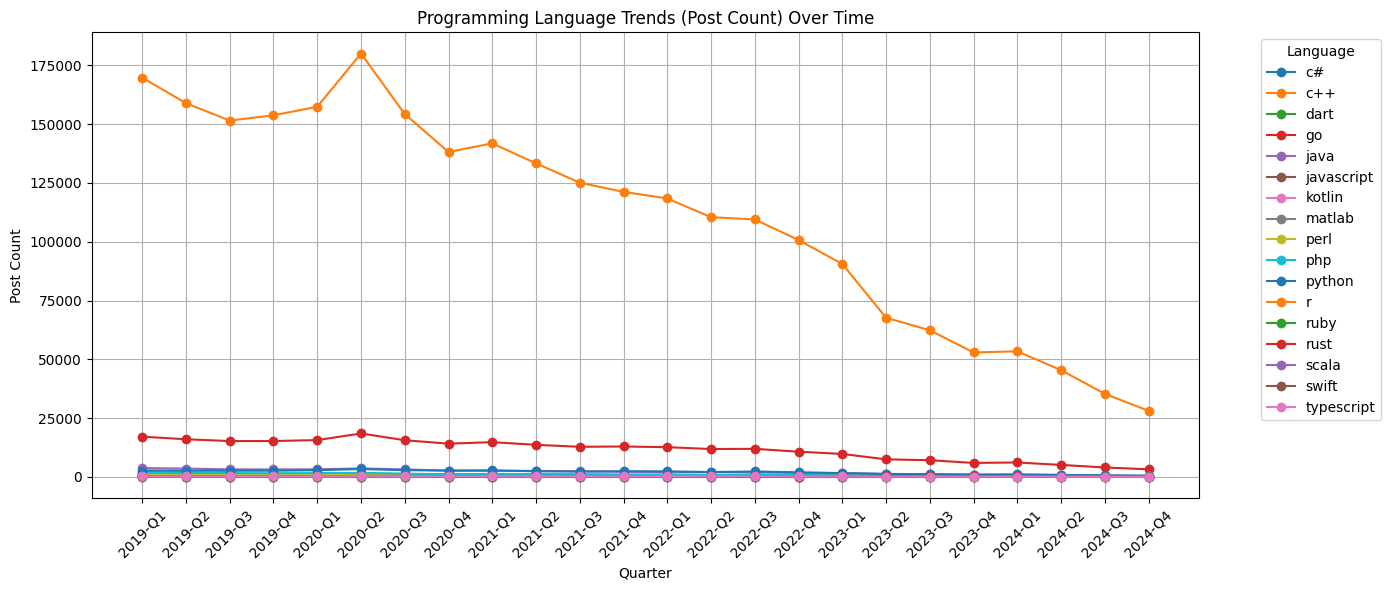

In [16]:
# STEP 1: Convert Spark DataFrame to Pandas
df_final_pd = final_df.toPandas()

# STEP 2: Pivot the data to have one line per language
trend_df = df_final_pd.pivot(index="quarter", columns="language", values="post_count")

# STEP 3: Plot with Matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
for column in trend_df.columns:
    plt.plot(trend_df.index, trend_df[column], marker='o', label=column)

plt.title("Programming Language Trends (Post Count) Over Time")
plt.xlabel("Quarter")
plt.ylabel("Post Count")
plt.xticks(rotation=45)
plt.legend(title="Language", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

The above trend plot is the overtime trend for all programming languages (post count)

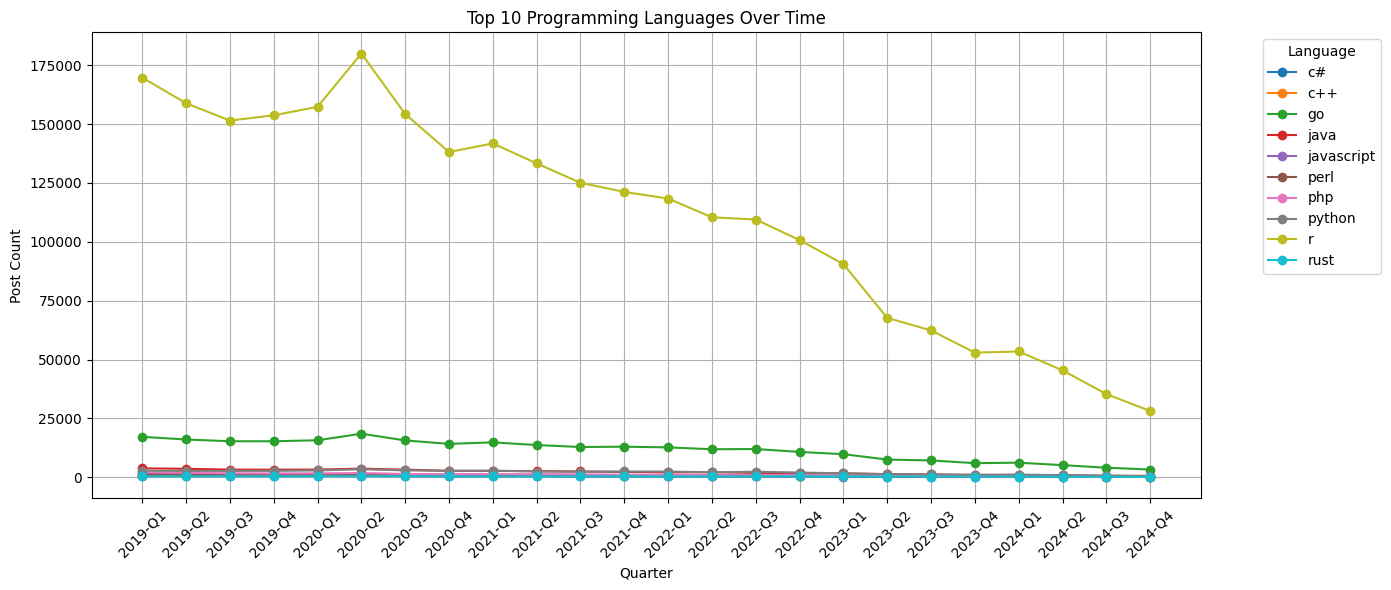

In [21]:
# STEP 1: Convert Spark DataFrame to Pandas
df_final_pd = final_df.toPandas()

# STEP 2: Get top 10 languages by total post count
top_10_langs = (
    df_final_pd.groupby("language")["post_count"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# STEP 3: Filter the original DataFrame to include only top 10 languages
df_top10 = df_final_pd[df_final_pd["language"].isin(top_10_langs)]

# STEP 4: Pivot the data to have one line per language
trend_df = df_top10.pivot(index="quarter", columns="language", values="post_count").fillna(0)

# STEP 5: Plot with Matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
for column in trend_df.columns:
    plt.plot(trend_df.index, trend_df[column], marker='o', label=column)

plt.title("Top 10 Programming Languages Over Time")
plt.xlabel("Quarter")
plt.ylabel("Post Count")
plt.xticks(rotation=45)
plt.legend(title="Language", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()


The above is the overtime trend for the top 10 programming languages that has the highest post count. We can see clearly that *R* language is declining really fast, and the post count including *R* shrinks to only about 30% in 2024-Q4 (50k) than the one in 2019-Q4 (150k). Then it's the language *go* has been declining. Further, we can see *Java* shrink slightly. For other languages, we might need to quantify the growth rate to see the trend as there are no explicit trend shown on the visualization.

3. A table of the top 5 fastest growing and top 5 fastest declining languages, measured by average quarterly growth rate





In [17]:
from pyspark.sql import Window
import pyspark.sql.functions as F

In [18]:
# Step 2: Calculate quarter-over-quarter growth using a window
window_spec = Window.partitionBy("language").orderBy("quarter")

df_growth = final_df.withColumn(
    "prev_post_count", F.lag("post_count").over(window_spec)
).withColumn(
    "growth_rate",
    F.when(F.col("prev_post_count").isNotNull(),
           ((F.col("post_count") - F.col("prev_post_count")) / F.col("prev_post_count")) * 100
    ).otherwise(None)
)

# Step 3: Calculate average growth rate per language
avg_growth_df = df_growth.groupBy("language").agg(
    F.avg("growth_rate").alias("avg_growth_rate")
).filter("avg_growth_rate IS NOT NULL")

In [19]:
# Step 4: Top 5 fastest growing
top_5_growing = avg_growth_df.orderBy(F.col("avg_growth_rate").desc()).limit(5)

# Step 5: Top 5 fastest declining
top_5_declining = avg_growth_df.orderBy(F.col("avg_growth_rate").asc()).limit(5)

# Step 6: Add category label and union both
top_5_growing = top_5_growing.withColumn("category", F.lit("Fastest Growing"))
top_5_declining = top_5_declining.withColumn("category", F.lit("Fastest Declining"))

summary_df = top_5_growing.union(top_5_declining)

In [20]:
# Show final result
summary_df.show(truncate=False)

+----------+-------------------+-----------------+
|language  |avg_growth_rate    |category         |
+----------+-------------------+-----------------+
|matlab    |-2.325270243233507 |Fastest Growing  |
|swift     |-3.361676825759572 |Fastest Growing  |
|typescript|-3.6493316057613594|Fastest Growing  |
|rust      |-3.796663951302187 |Fastest Growing  |
|dart      |-4.0910464669188515|Fastest Growing  |
|php       |-9.159398543045112 |Fastest Declining|
|javascript|-7.951366576983174 |Fastest Declining|
|java      |-7.667167895240001 |Fastest Declining|
|r         |-7.091402825069673 |Fastest Declining|
|scala     |-6.860654594059883 |Fastest Declining|
+----------+-------------------+-----------------+



From the above table, all type of programming languages declines for the past 5 years. However, we will filter out the 5 Fastest Growing and 5 Fastest declining programming languages. The 5 Fastest Growing languages includes matlab, swift, typescript, rust, and dart. The 5 Fastest declining languages includes php, javascript, java, r, and scala.